## Post-flica processing

- Plot convergence rate
- filter for minimum 20% resting state contributions
- filter for subject contributions (if one subject > 1% -> out, not likely)
- plot component maps (problem for diff)

TODO:
- save modality bars + update color scheme (but later)
- final figure making should be with mrview + handwork or sth anyway

Last update: March 6, 2024, Jitse Amelink

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [5]:
#general paths
workspace_path = "/data/workspaces/lag/workspaces/lg-ukbiobank/projects/FLICA_multimodal/"
cfs_path = "/data/clusterfs/lag/users/jitame/FLICA/pheno"
flica_base_path = "/data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal"

#26k paths
flica_out_path_25c = os.path.join(flica_base_path, "flica_out_4mods_26k_25c")
flica_out_path_50c = os.path.join(flica_base_path, "flica_out_4mods_26k_50c")
flica_out_path_100c = os.path.join(flica_base_path, "flica_out_4mods_26k_100c")
sub_fn = os.path.join(workspace_path, "ifl_files_in_N26659.txt")

#28k paths
flica_out_path_28k_25c = os.path.join(flica_base_path, "flica_out_5mods_28k_25c")
flica_out_path_28k_50c = os.path.join(flica_base_path, "flica_out_5mods_28k_50c")
flica_out_path_28k_100c = os.path.join(flica_base_path, "flica_out_5mods_28k_100c")
sub_fn_28k = os.path.join(workspace_path, "ifl_files_in_N28518.txt")

flica_out_path_32k_3c = os.path.join(flica_base_path, "flica_out_4mods_32k_3c")
flica_out_path_32k_4c = os.path.join(flica_base_path, "flica_out_4mods_32k_4c")
flica_out_path_32k_5c = os.path.join(flica_base_path, "flica_out_4mods_32k_5c")
flica_out_path_32k_6c = os.path.join(flica_base_path, "flica_out_4mods_32k_6c")
flica_out_path_32k_7c = os.path.join(flica_base_path, "flica_out_4mods_32k_7c")
flica_out_path_32k_10c = os.path.join(flica_base_path, "flica_out_4mods_32k_10c")

flica_out_path_32k_5c_R = os.path.join(flica_base_path, "flica_out_4mods_32k_5c_R")
flica_out_path_32k_10c_R = os.path.join(flica_base_path, "flica_out_4mods_32k_10c_R")
flica_out_path_32k_15c_R = os.path.join(flica_base_path, "flica_out_4mods_32k_15c_R")
flica_out_path_32k_25c_R = os.path.join(flica_base_path, "flica_out_4mods_32k_25c_R")
flica_out_path_32k_50c_R = os.path.join(flica_base_path, "flica_out_4mods_32k_50c_R")


flica_out_path_32k_30c = os.path.join(flica_base_path, "flica_out_4mods_32k_30c")
flica_out_path_32k_50c = os.path.join(flica_base_path, "flica_out_4mods_32k_50c")
sub_fn_32k = os.path.join(flica_base_path, "flica_32k_subs_final.txt")

#filtering thresholds
mmi_thresh = 0.4
rs_thresh = 0.2
subj_thresh = 0.01

## Utils

In [6]:
def mmi(n_mods, weight_mod_mat):
    """
    Inputs:
    - number of modalities
    - modality weights (modalities x component weights)
    
    Outputs:
    - Multimodal index per component.
    
    See supplementary: see Francx et al., 2016.
    https://www.sciencedirect.com/science/article/pii/S2213158216300468
    """
    
    mod_score = np.max(weight_mod_mat, axis=0)-(1/n_mods)
    
    return 1-(n_mods*(mod_score/(n_mods-1)))

def filter_comps(flica_out_path, sub_fn, subj_thresh):
    """
    Inputs:
    - subject courses x components
    
    Outputs:
    - 
    """
    subj_loads = np.loadtxt(os.path.join(flica_out_path, "subjectCoursesOut.txt"))
    
    #calculate maximum contribution per subject
    subj_loads_dom = np.max(np.abs(subj_loads), axis=1)/np.sum(np.abs(subj_loads), axis=1)
    
    #check if above threshold
    subj_bool = subj_loads_dom < subj_thresh
    
    #create dataframe
    subj_loads_out = pd.DataFrame(subj_loads.T,
                                  index = get_subj_names2(sub_fn))
    
    return subj_loads_out, subj_bool

def get_subj_names(fn):
    subs_in_file1 = open(fn)
    return [ int(os.path.split(os.path.split(x)[0])[1]) for x in list(subs_in_file1.read().split('\n'))[:-1] ]

def get_subj_names2(fn):
    subs_in_file1 = open(fn)
    return [ int(x) for x in list(subs_in_file1.read().split('\n'))[:-1] ]


def get_modality_names(flica_out_path):
    mod_fn = open(os.path.join(flica_out_path, "order_of_loaded_data.txt"))
    return [ os.path.split(os.path.split(x)[0])[1]  for x in list( mod_fn.read().split('\n') )[:-1] ]
    
def plot_multimodal(mod_weights, flica_out_path, in_bool):
    df2 = pd.DataFrame(mod_weights.T, columns = get_modality_names(flica_out_path) )
    df2.reindex(sorted(df2.columns), axis=1)
    df2.loc[in_bool, :].plot.barh(stacked=True,figsize=(10,10),colormap="tab20b");
    ax = plt.title('Relative weight of modalities in each multimodal component')   
    plt.ylabel('Component index')
    plt.xlabel('Fraction of weight')

def plot_all(mod_weights, flica_out_path, fname):
    df2 = pd.DataFrame(mod_weights.T, columns = get_modality_names(flica_out_path) )
    df2.plot.barh(stacked=True,figsize=(10,10),colormap="tab20b");
    plt.title('Relative weight of modalities in each component')   
    plt.ylabel('Component index')
    plt.xlabel('Fraction of weight')
    plt.savefig(fname, dpi=300)
    
def output_gcta_regenie(out_fn, df):
    df["FID"] = df.index.values
    df["IID"] = df.index.values
    df[ ['FID', 'IID'] + list(df.columns[:-2]) ].to_csv(out_fn+"_gcta_N{}.tsv".format(df.shape[0]) , sep = "\t", index = False, header = True)
    
def post_flica_filter(flica_out_path, sub_fn, mmi_thresh=0.4, rs_thresh=0.2, subj_thresh=0.01, fig_fname=None):
    """
    Entire filtering pipeline:
    1. Filter for multimodality
    2. Filter for subject dominance
    
    Return:
    - Subj loadings

    """
    print("Decomposition results from: {} \n".format(flica_out_path))
    print("Modalities:")
    print(get_modality_names(flica_out_path))
    
    #0. Plot all
    mod_weights = np.loadtxt(os.path.join(flica_out_path, "Modality_contributions.txt"))
    plot_all(mod_weights, flica_out_path, fname=fig_fname)
    
    ## 1. Filter rs contribution
    mods_df = pd.DataFrame(mod_weights.T, columns = get_modality_names(flica_out_path) )
    rs_bool = np.logical_or(mods_df["rs_mtl"] > rs_thresh, mods_df["rs_ifl"] > rs_thresh)
    
    #print(rs_bool)
    
    #N/A: filter multimodality
    mmis = mmi(mod_weights.shape[0], mod_weights)
    mod_bool = mmis > mmi_thresh
    multimodal_bool = np.logical_and(mod_bool, rs_bool)
    
    ## 2. Filter subject courses for subject dominance
    subj_loads, subj_bool = filter_comps(flica_out_path, sub_fn, subj_thresh)
    
    indices = np.where(subj_bool==True)
    print("Components with subject dominance below {1}:".format(mmi_thresh, subj_thresh))
    print(indices)
    
    ## 3. Combine filtering
    filter_bool = np.logical_and(subj_bool, multimodal_bool)
    indices = np.asarray(filter_bool==True).nonzero()
    print("Multimodal components with both filters:".format(mmi_thresh, subj_thresh))
    print(indices)
    
    ## 4. plot

    ## 5. Return multimodal comps
    return subj_loads.loc[:, filter_bool] #, indices[0].tolist()

In [7]:
from nilearn import image, plotting

def load_modality_maps(flica_out_path, mods):
    """
    Loads component loadings from output directory
    
    Returns:
    - dictionary with labels and nifti1-images.
    """
    niftis = dict()
    for i, mod in enumerate(mods):
        mod_nifti = image.load_img(os.path.join(flica_out_path, "niftiOut_mi{}.nii.gz".format(i+1)))
        niftis.update({mod: mod_nifti})
    return niftis

def plot_component(niftis, component_no, mods, out_path):
    """
    Plot all modality maps for one component
    Saves:
    - figure
    """
    
    print("Plotting component number {}".format(component_no))
    
    fig_args = {"figsize":(10,16),"dpi":400}
    

    fig, ax = plt.subplots(nrows = len(mods), ncols = 1,  gridspec_kw={'height_ratios': [1]*len(mods)}, **fig_args)

    fig.suptitle("Modality contributions for component {}".format(component_no), y=0.93, fontsize=24)
    
    
    #TODO: add modality contributions top (or left)
    #TODO: set maximum the same across modalities
    
    for i, mod in enumerate(mods):
        if mod == "afd":
            #get empty image
            print("Plot modality: {}".format(mod))
            ref_img = image.index_img(niftis["rs_mtl"], 0)                          
            empty_img = image.new_img_like(ref_img, np.zeros(ref_img.shape))
            
            #plot
            display = plotting.plot_glass_brain(empty_img, display_mode='lyrz', cmap="seismic", threshold=3, colorbar=True, plot_abs=False,
                                                title=mod, axes=ax[i])
            display.close()
        
        else:
            #plot
            print("Plot modality: {}".format(mod))
            display = plotting.plot_glass_brain(image.index_img(niftis[mod], int(component_no)), display_mode='lyrz', cmap="seismic", threshold=3, colorbar=True, plot_abs=False,
                                                title=mod, axes=ax[i])
            display.close()
        

    fig.savefig(fname=os.path.join(out_path, "component_{}.png".format(component_no)), bbox_inches="tight")

    
def plot_all_components_all_paths(flica_paths, components_lists, out_paths):
    """
    Wrapper that loops over all results
    
    """
    for path, comp_list, out_path in zip(flica_paths, components_lists, out_paths):
        #load data
        print("Running path: {}".format(path))
        mods = get_modality_names(path)

        niftis = load_modality_maps(path, mods)
        
        os.makedirs(out_path, exist_ok=True)
        
        #plot components
        for comp in comp_list:
            plot_component(niftis, comp, mods, out_path)

Decomposition results from: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_32k_5c_R 

Modalities:
['rs_mtl', 'afd', 'tbm', 'rs_ifl']
Components with subject dominance below 0.01:
(array([0, 1, 2, 3, 4]),)
Multimodal components with both filters:
(array([2]),)


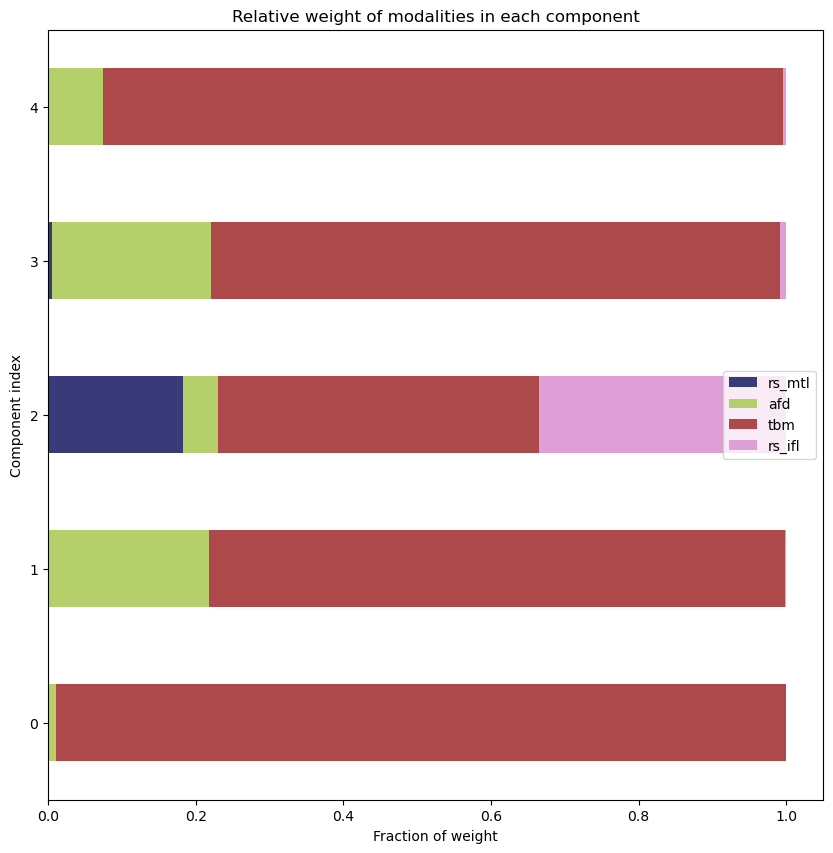

In [12]:
subj_loadings_5c = post_flica_filter(flica_out_path_32k_5c_R,
                                  sub_fn_32k,
                                  mmi_thresh=mmi_thresh,
                                  rs_thresh=rs_thresh,
                                  subj_thresh=subj_thresh,
                                    fig_fname=os.path.join(workspace_path, "results", "5c_decomposition.png"))

Decomposition results from: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_32k_10c_R 

Modalities:
['rs_mtl', 'afd', 'tbm', 'rs_ifl']
Components with subject dominance below 0.01:
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)
Multimodal components with both filters:
(array([4]),)


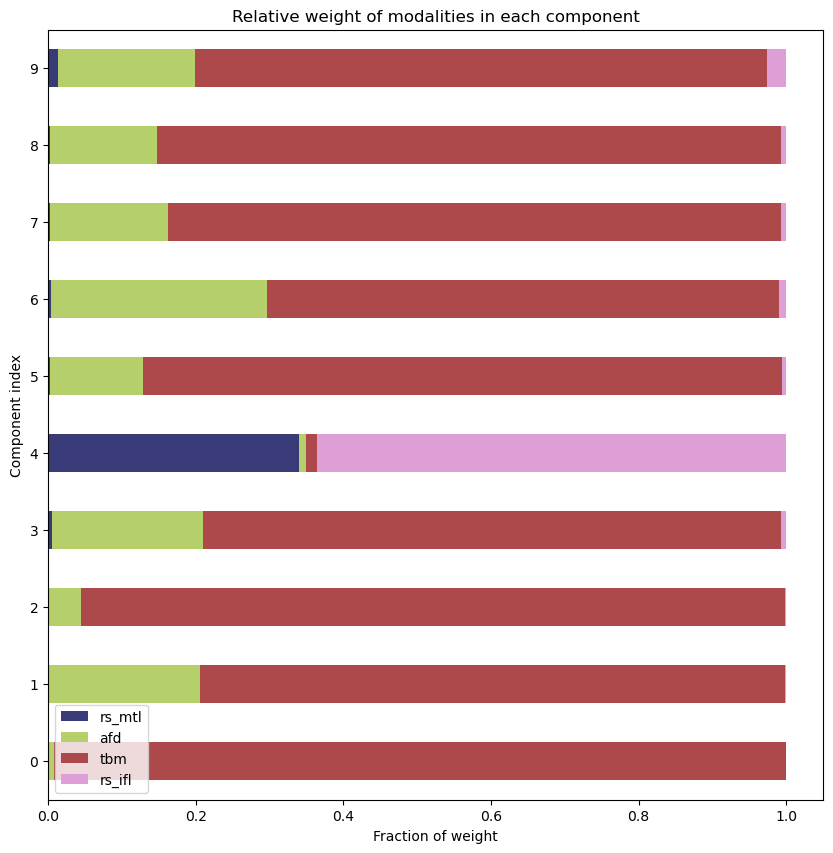

In [13]:
subj_loadings_10c_R = post_flica_filter(flica_out_path_32k_10c_R,
                                  sub_fn_32k,
                                  mmi_thresh=mmi_thresh,
                                  rs_thresh=rs_thresh,
                                  subj_thresh=subj_thresh,
                                  fig_fname=os.path.join(workspace_path, "results", "10c_decomposition.png"))

Decomposition results from: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_32k_50c_R 

Modalities:
['rs_mtl', 'afd', 'tbm', 'rs_ifl']
Components with subject dominance below 0.01:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),)
Multimodal components with both filters:
(array([ 6, 35]),)


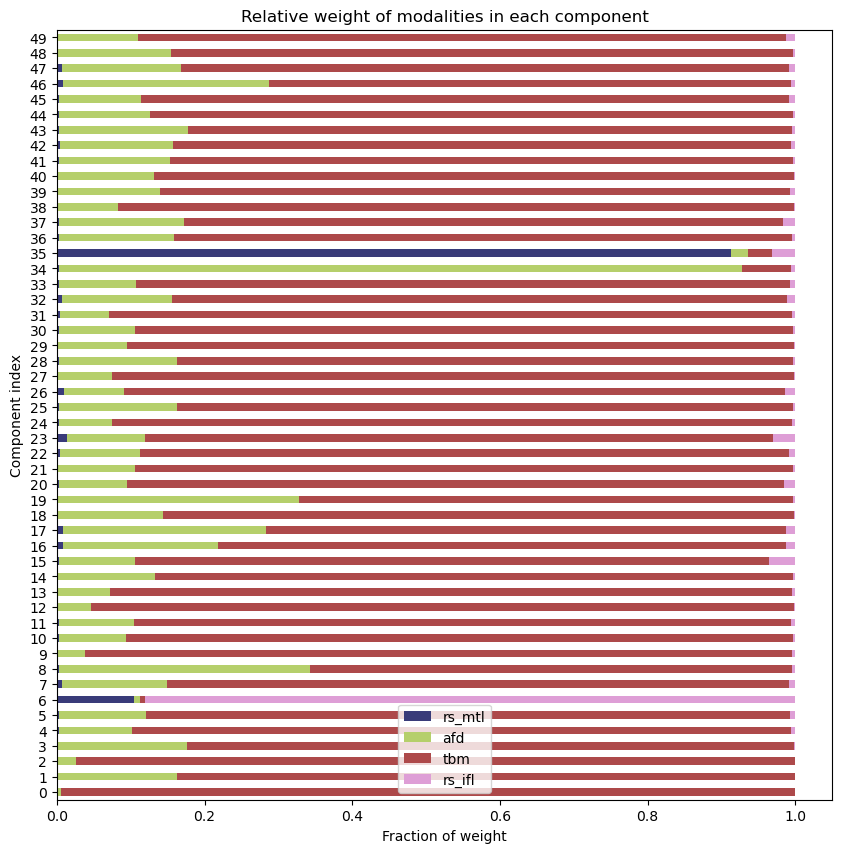

In [8]:
subj_loadings_50c_R = post_flica_filter(flica_out_path_32k_50c_R,
                                  sub_fn_32k,
                                  mmi_thresh=0.1,
                                  rs_thresh=rs_thresh,
                                  subj_thresh=subj_thresh,
                                  fig_fname=os.path.join(workspace_path, "results", "50c_decomposition.png"))

In [9]:
figure_path = os.path.join(workspace_path, "results", "figures")

plot_all_components_all_paths(flica_paths = [ flica_out_path_32k_5c_R ],
                             components_lists = [ [ 0, 1, 2, 3, 4 ] ],
                             out_paths = [ os.path.join(figure_path, "5c_32k_R") ])

Running path: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_32k_5c_R
Plotting component number 0
Plot modality: rs_mtl
Plot modality: afd


/home/jitame/bin/anaconda3/envs/results_env/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 1
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 2
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 3
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 4
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl


In [11]:
figure_path = os.path.join(workspace_path, "results", "figures")

plot_all_components_all_paths(flica_paths = [ flica_out_path_32k_10c_R ],
                             components_lists = [ [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ] ],
                             out_paths = [ os.path.join(figure_path, "10c_32k_R") ])

Running path: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_32k_10c_R
Plotting component number 0
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 1
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 2
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 3
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 4
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 5
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 6
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 7
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs

In [14]:
out_df = pd.concat( [ subj_loadings_5c, subj_loadings_10c_R ] , axis=1 )

In [15]:
out_df.columns = ["5c_extended", "10c_narrow"]

In [21]:
repl_df = subj_loadings_50c_R.iloc[:,:2]
repl_df.columns=["50c_IFL", "50c_MTL"]
all_df = pd.concat([out_df, repl_df], axis=1)

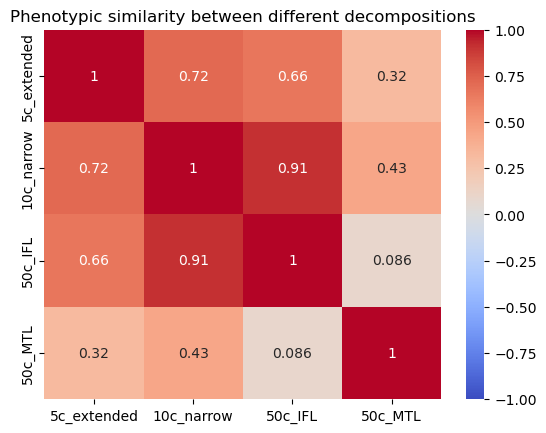

In [24]:
import seaborn as sns
sns.heatmap(all_df.corr(), cmap="coolwarm", vmin=-1, vmax=1, annot=True)
plt.title("Phenotypic similarity between different decompositions")
plt.savefig(os.path.join(workspace_path, "results", "pheno_corr.png"))

In [78]:
output_gcta_regenie(os.path.join(cfs_path, "rs_ics_32k"), out_df)

,6,35,FID,IID
1000099,-0.623508,-0.014907,1000099,1000099
1000192,-0.869604,0.415426,1000192,1000192
1000256,0.453767,0.457978,1000256,1000256
1000281,0.461690,3.622049,1000281,1000281
1000330,0.690257,0.129372,1000330,1000330


In [9]:
output_gcta_regenie(os.path.join(cfs_path, "rs_50c_32k"), subj_loadings_50c_R)

<AxesSubplot: >

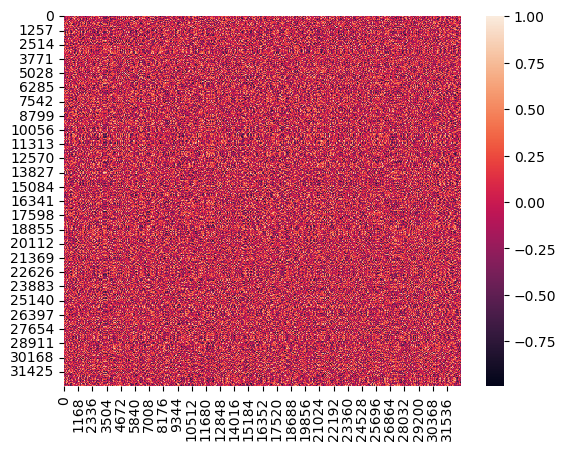

In [8]:
import seaborn as sns
sns.heatmap(np.corrcoef(pd.concat([subj_loadings_10c, subj_loadings_10c_R], axis=1)))

Decomposition results from: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_32k_15c 

Modalities:
['rs_ifl', 'rs_mtl', 'tbm', 'afd']
Components with subject dominance below 0.01:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),)
Multimodal components with both filters:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),)


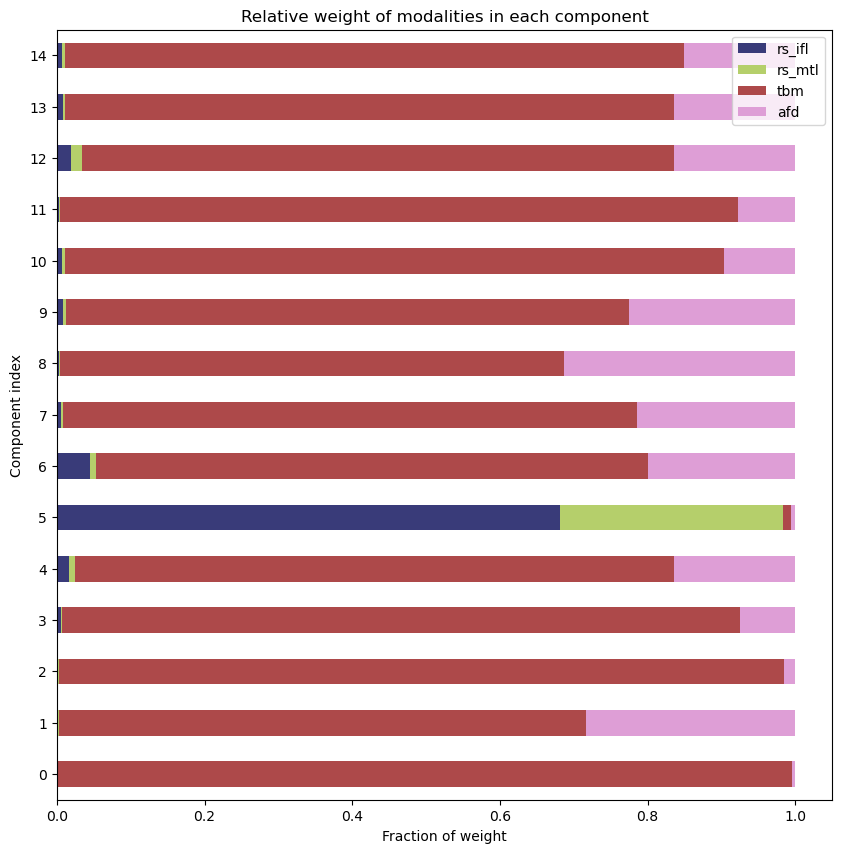

In [9]:
subj_loadings_15c = post_flica_filter(flica_out_path_32k_15c,
                                  sub_fn_32k,
                                  rs_thresh,
                                  subj_thresh)

Decomposition results from: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_32k_3c 

Modalities:
['rs_ifl', 'rs_mtl', 'tbm', 'afd']
Components with subject dominance below 0.01:
(array([0, 1, 2]),)
Multimodal components with both filters:
(array([0, 1, 2]),)


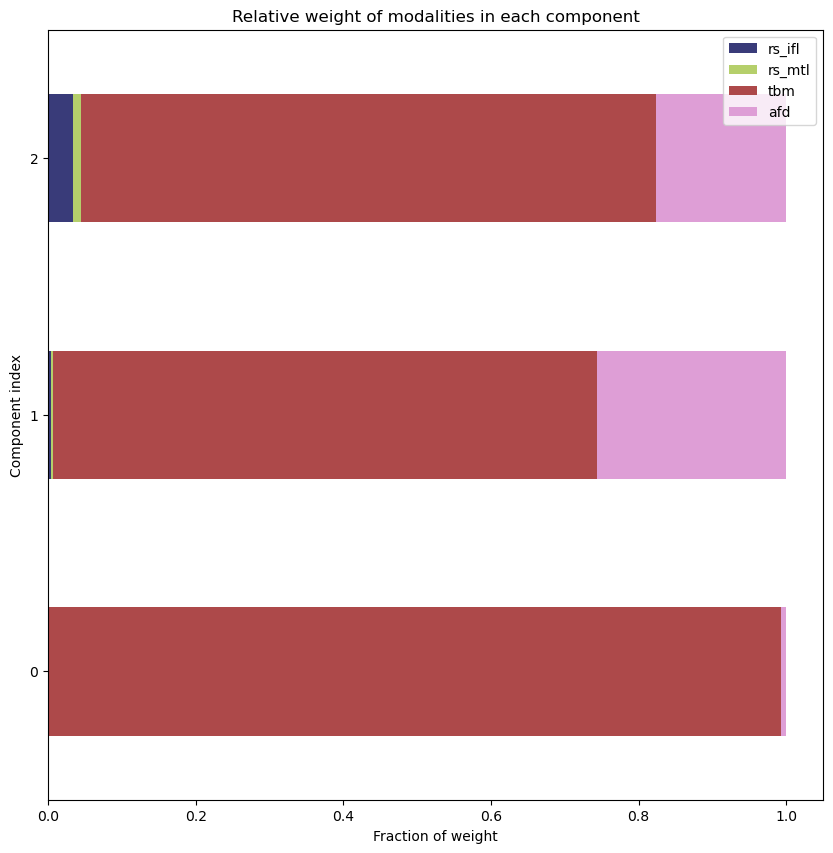

In [6]:
subj_loadings_3c = post_flica_filter(flica_out_path_32k_3c,
                                  sub_fn_32k,
                                  rs_thresh,
                                  subj_thresh)

Decomposition results from: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_32k_4c 

Modalities:
['rs_mtl', 'afd', 'tbm', 'rs_ifl']
Components with subject dominance below 0.01:
(array([0, 1, 2, 3]),)
Multimodal components with both filters:
(array([0, 1, 2, 3]),)


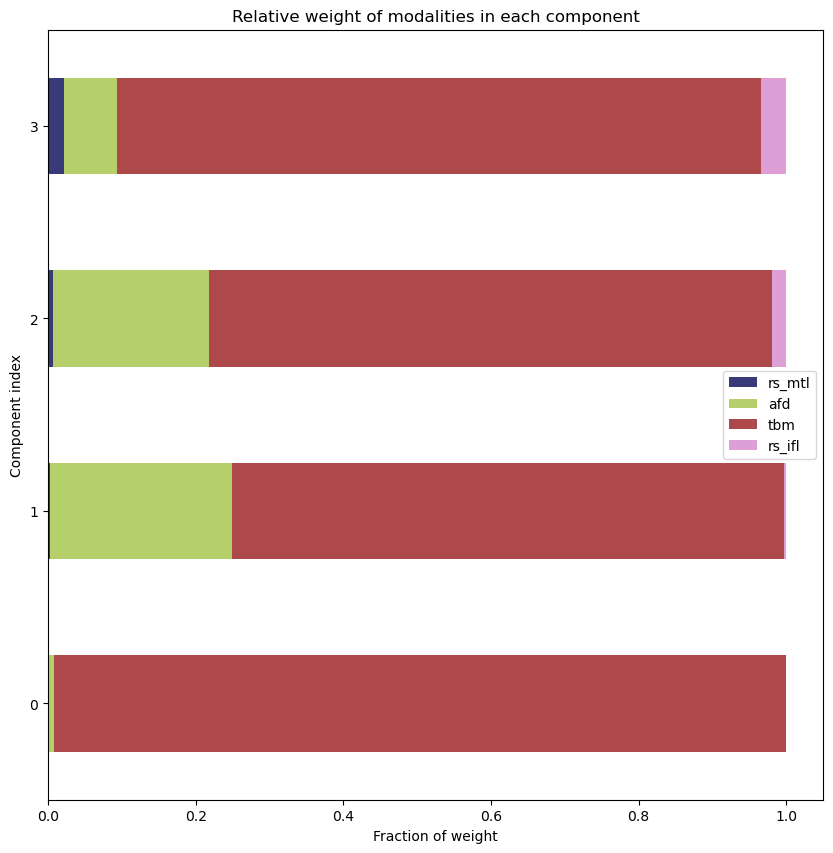

In [7]:
subj_loadings_4c = post_flica_filter(flica_out_path_32k_4c,
                                  sub_fn_32k,
                                  rs_thresh,
                                  subj_thresh)

Decomposition results from: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_32k_6c 

Modalities:
['rs_mtl', 'afd', 'tbm', 'rs_ifl']
Components with subject dominance below 0.01:
(array([0, 1, 2, 3, 4, 5]),)
Multimodal components with both filters:
(array([0, 1, 2, 3, 4, 5]),)


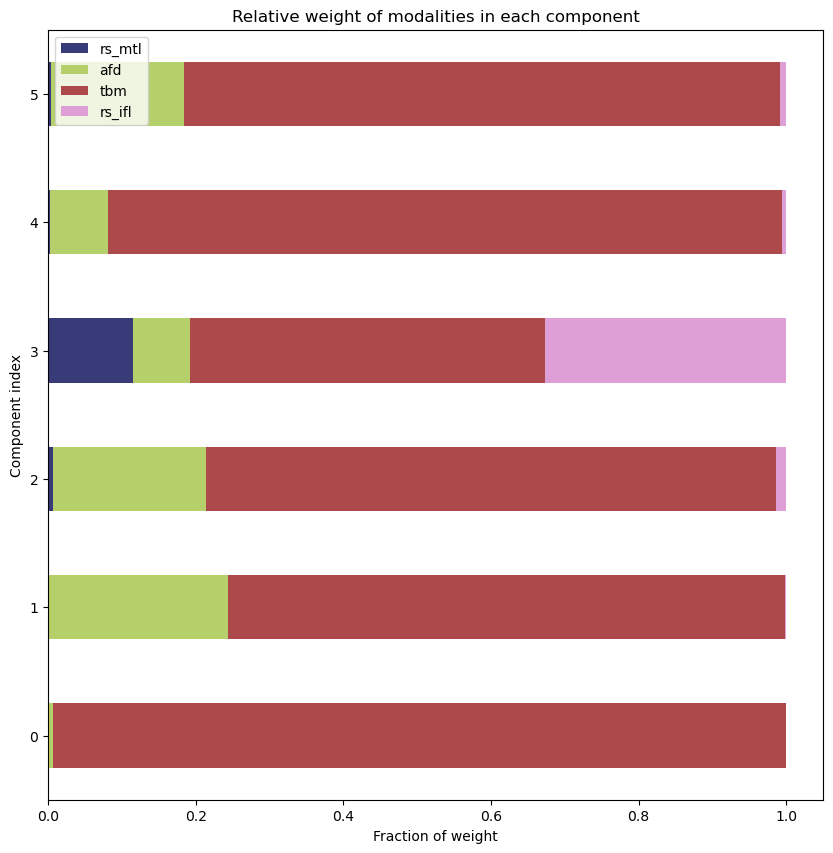

In [9]:
subj_loadings_6c = post_flica_filter(flica_out_path_32k_6c,
                                  sub_fn_32k,
                                  rs_thresh,
                                  subj_thresh)

Decomposition results from: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_32k_7c 

Modalities:
['rs_mtl', 'afd', 'tbm', 'rs_ifl']
Components with subject dominance below 0.01:
(array([0, 1, 2, 3, 4, 5, 6]),)
Multimodal components with both filters:
(array([0, 1, 2, 3, 4, 5, 6]),)


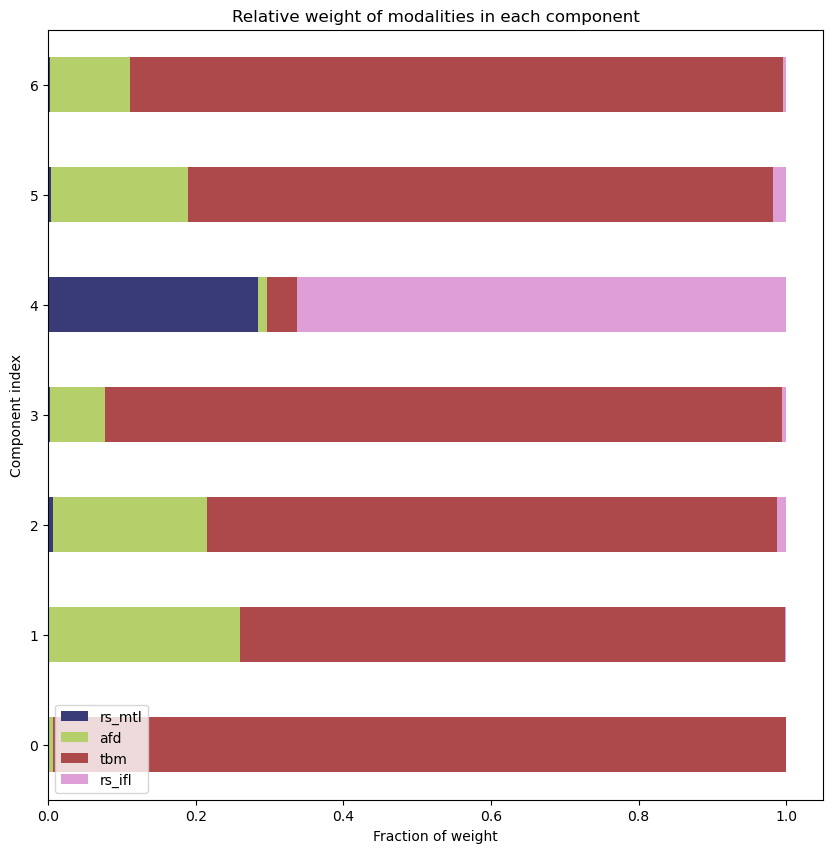

In [8]:
subj_loadings_7c = post_flica_filter(flica_out_path_32k_7c,
                                  sub_fn_32k,
                                  rs_thresh,
                                  subj_thresh)

Decomposition results from: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_32k_50c 

Modalities:
['rs_ifl', 'rs_mtl', 'tbm', 'afd']
Components with subject dominance below 0.01:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),)
Multimodal components with both filters:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),)


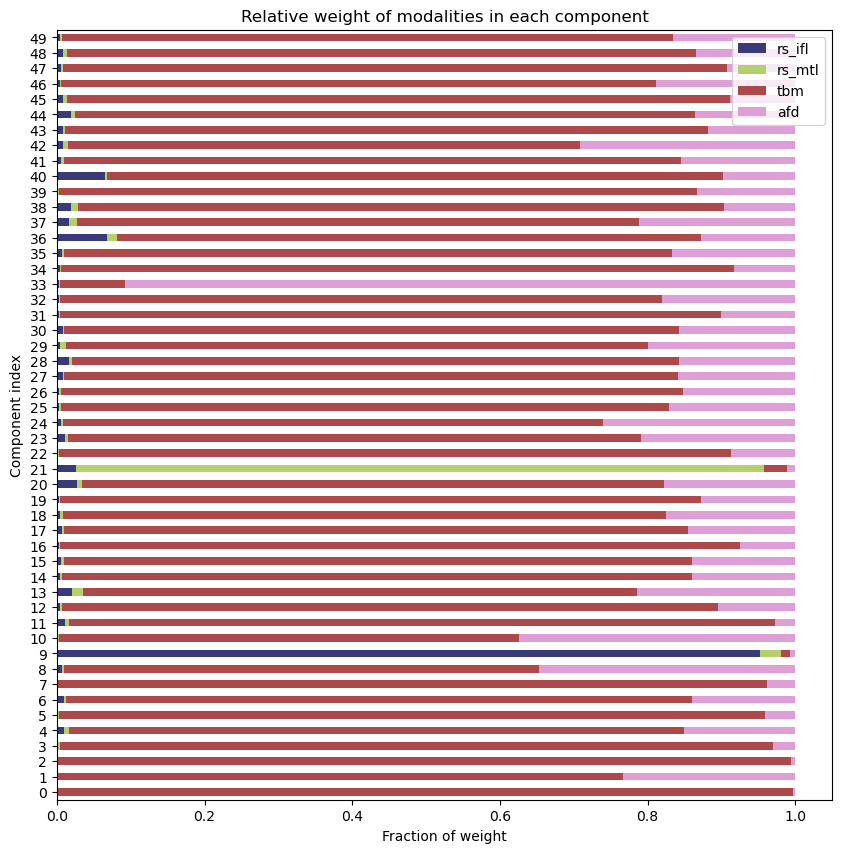

In [12]:
subj_loadings_50c = post_flica_filter(flica_out_path_32k_50c,
                                  sub_fn_32k,
                                  rs_thresh,
                                  subj_thresh)

Decomposition results from: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_32k_15c 

Modalities:
['rs_ifl', 'rs_mtl', 'tbm', 'afd']
Components with subject dominance below 0.01:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),)
Multimodal components with both filters:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),)


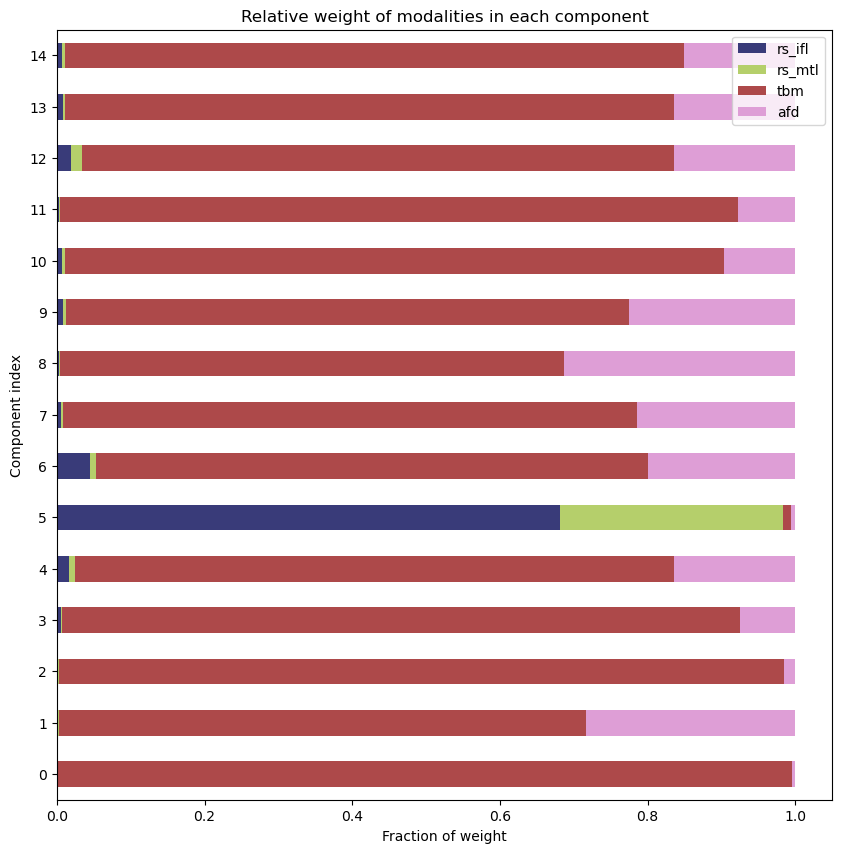

In [21]:
subj_loadings_15c = post_flica_filter(flica_out_path_32k_15c,
                                  sub_fn_32k,
                                  rs_thresh,
                                  subj_thresh)

In [12]:
figure_path = os.path.join(workspace_path, "results", "figures")

plot_all_components_all_paths(flica_paths = [ flica_out_path_32k_7c ],
                             components_lists = [ [ 0, 1, 2, 3, 4, 5, 6 ] ],
                             out_paths = [ os.path.join(figure_path, "7c_32k") ])

Running path: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_32k_7c
Plotting component number 0
Plot modality: rs_mtl
Plot modality: afd


/home/jitame/bin/anaconda3/envs/results_env/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 1
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 2
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 3
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 4
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 5
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 6
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl


In [11]:
figure_path = os.path.join(workspace_path, "results", "figures")

plot_all_components_all_paths(flica_paths = [ flica_out_path_32k_10c ],
                             components_lists = [ [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ] ],
                             out_paths = [ os.path.join(figure_path, "10c_32k") ])

Running path: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_32k_10c
Plotting component number 0
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd


/home/jitame/bin/anaconda3/envs/results_env/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


Plotting component number 1
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd
Plotting component number 2
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd
Plotting component number 3
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd
Plotting component number 4
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd
Plotting component number 5
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd
Plotting component number 6
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd
Plotting component number 7
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd
Plotting component number 8
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd
Plotting component number 9
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd


In [28]:
figure_path = os.path.join(workspace_path, "results", "figures")

plot_all_components_all_paths(flica_paths = [ flica_out_path_32k_15c ],
                             components_lists = [ [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14 ] ],
                             out_paths = [ os.path.join(figure_path, "15c_32k") ])

Running path: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_32k_15c
Plotting component number 0
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd


/home/jitame/bin/anaconda3/envs/results_env/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


Plotting component number 1
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd
Plotting component number 2
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd
Plotting component number 3
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd
Plotting component number 4
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd
Plotting component number 5
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd
Plotting component number 6
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd
Plotting component number 7
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd
Plotting component number 8
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd
Plotting component number 9
Plot modality: rs_ifl
Plot modality: rs_mtl
Plot modality: tbm
Plot modality: afd
Plotting c

In [13]:
figure_path = os.path.join(workspace_path, "results", "figures")

plot_all_components_all_paths(flica_paths = [ flica_out_path_32k_6c ],
                             components_lists = [ [ 0, 1, 2, 3, 4, 5 ] ],
                             out_paths = [ os.path.join(figure_path, "6c_32k") ])

Running path: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_32k_6c
Plotting component number 0
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 1
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 2
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 3
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 4
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl
Plotting component number 5
Plot modality: rs_mtl
Plot modality: afd
Plot modality: tbm
Plot modality: rs_ifl


<Figure size 2000x2000 with 0 Axes>

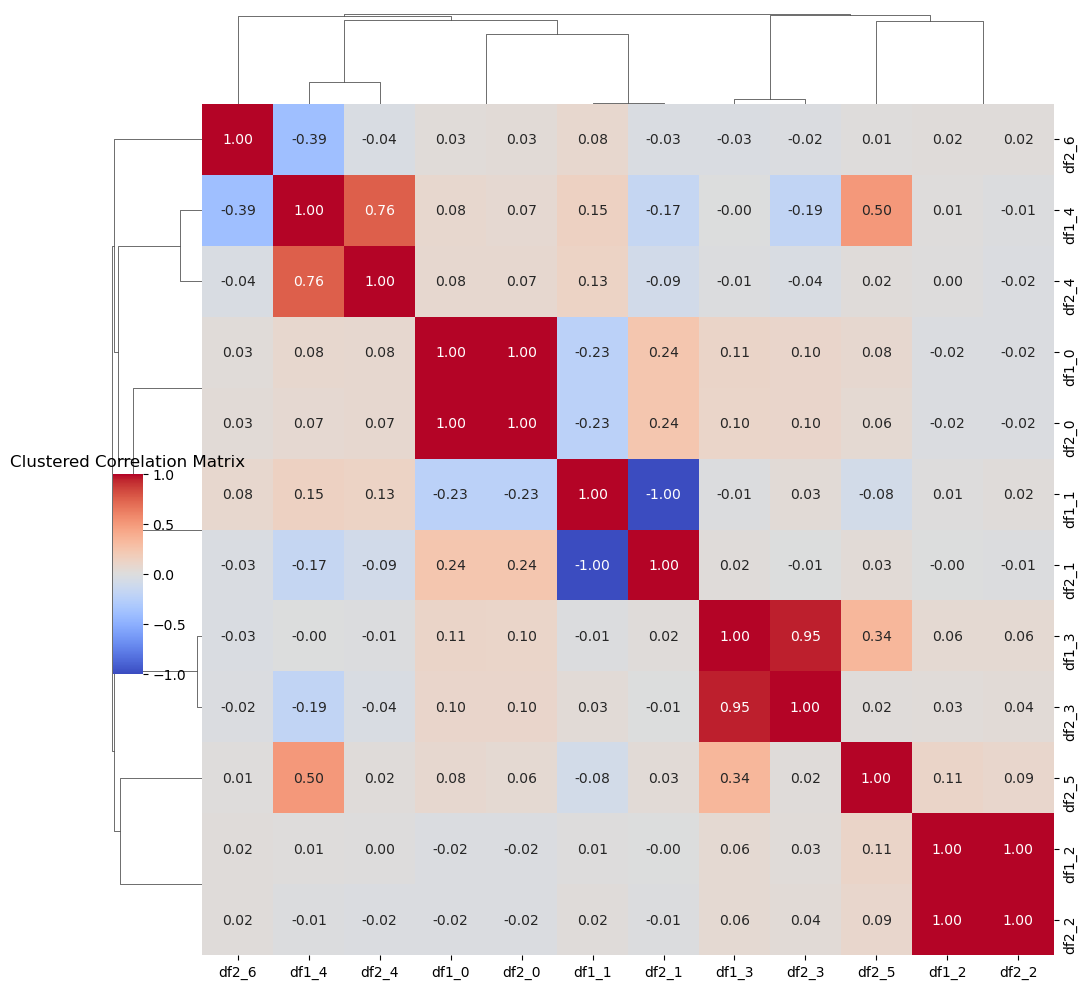

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform


def get_clustered_correlation_matrix(dataframes, prefixes=None, figsize=(20, 20)):
    """
    Compute and plot correlation matrix with hierarchical clustering
    """
    if prefixes is None:
        prefixes = [f"df{i+1}_" for i in range(len(dataframes))]
    
    # Rename and combine dataframes
    renamed_dfs = []
    for df, prefix in zip(dataframes, prefixes):
        df_copy = df.copy()
        df_copy.columns = [f"{prefix}{col}" for col in df.columns]
        renamed_dfs.append(df_copy)
    
    combined = pd.concat(renamed_dfs, axis=1)
    corr_matrix = combined.corr()
    
    # Compute linkage matrix for clustering
    dissimilarity = 1 - np.abs(corr_matrix)
    linkage = hierarchy.linkage(squareform(dissimilarity), method='complete')
    
    # Create clustered heatmap
    plt.figure(figsize=figsize)
    g = sns.clustermap(corr_matrix,
                       cmap='coolwarm',
                       center=0,
                       vmin=-1,
                       vmax=1,
                       annot=True,
                       fmt='.2f',
                       row_linkage=linkage,
                       col_linkage=linkage,
                       dendrogram_ratio=(.1, .1),
                       cbar_pos=(0.02, .32, .03, .2))
    
    plt.title('Clustered Correlation Matrix')
    return corr_matrix


cross_corrs = get_clustered_correlation_matrix([subj_loadings_5c, subj_loadings_7c])



<Figure size 2000x2000 with 0 Axes>

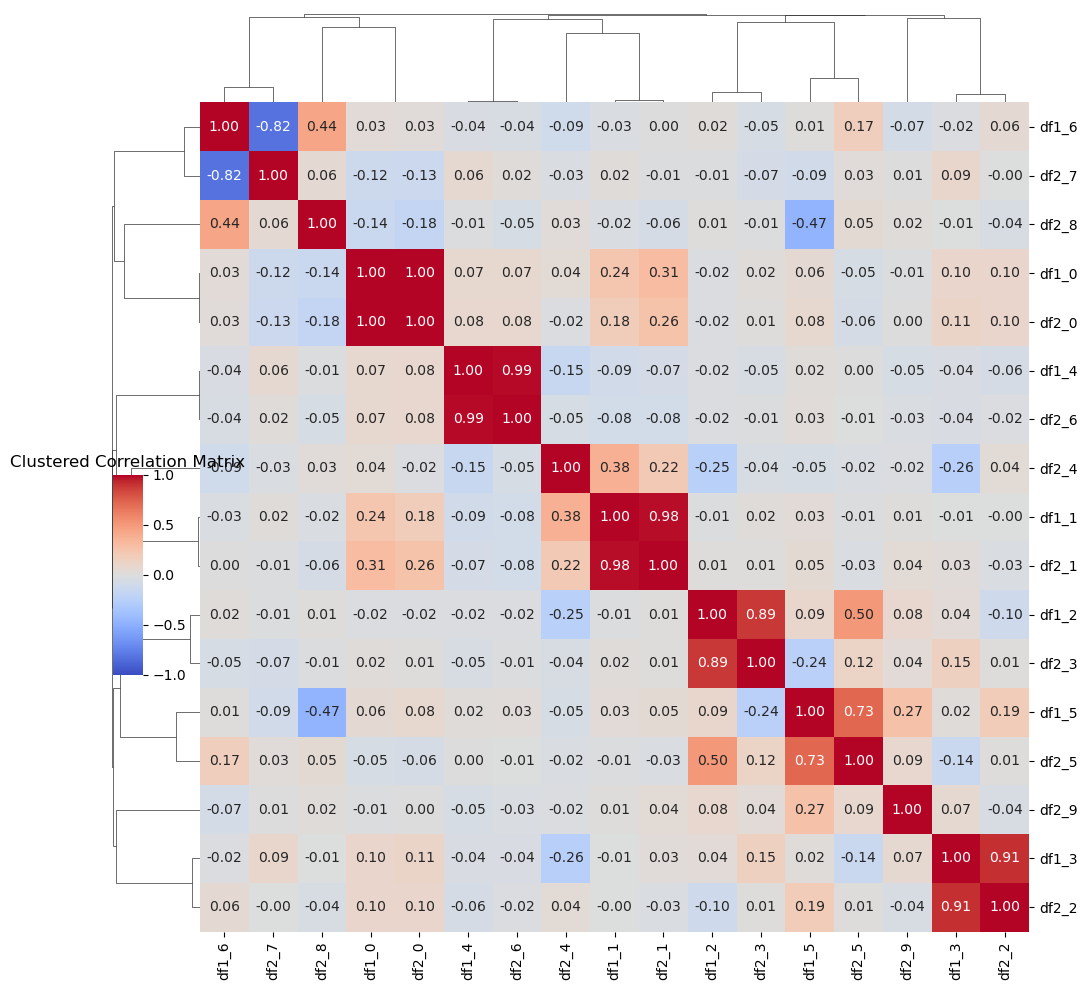

In [25]:
cross_corrs = get_clustered_correlation_matrix([subj_loadings_7c, subj_loadings_10c])


<Figure size 2000x2000 with 0 Axes>

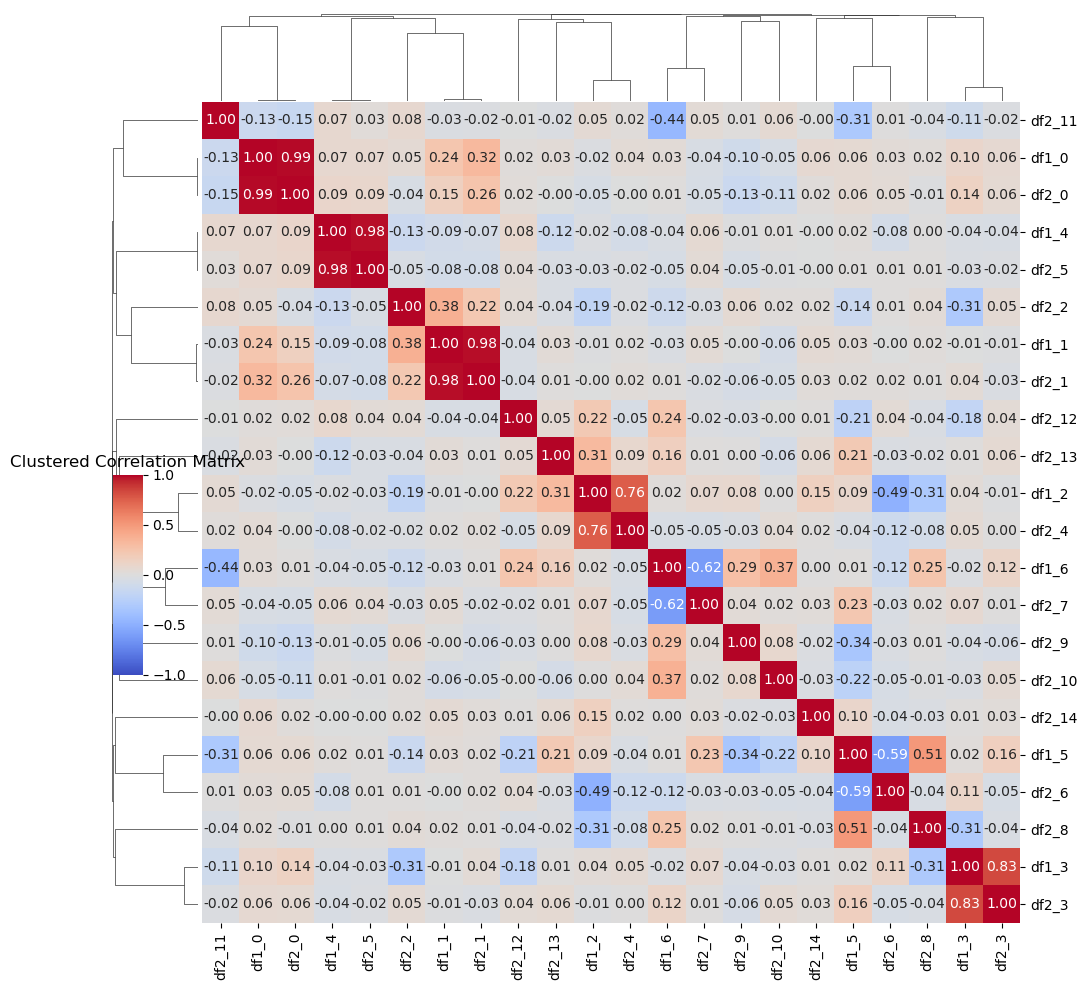

In [26]:
cross_corrs = get_clustered_correlation_matrix([subj_loadings_7c, subj_loadings_15c])


<Figure size 2000x2000 with 0 Axes>

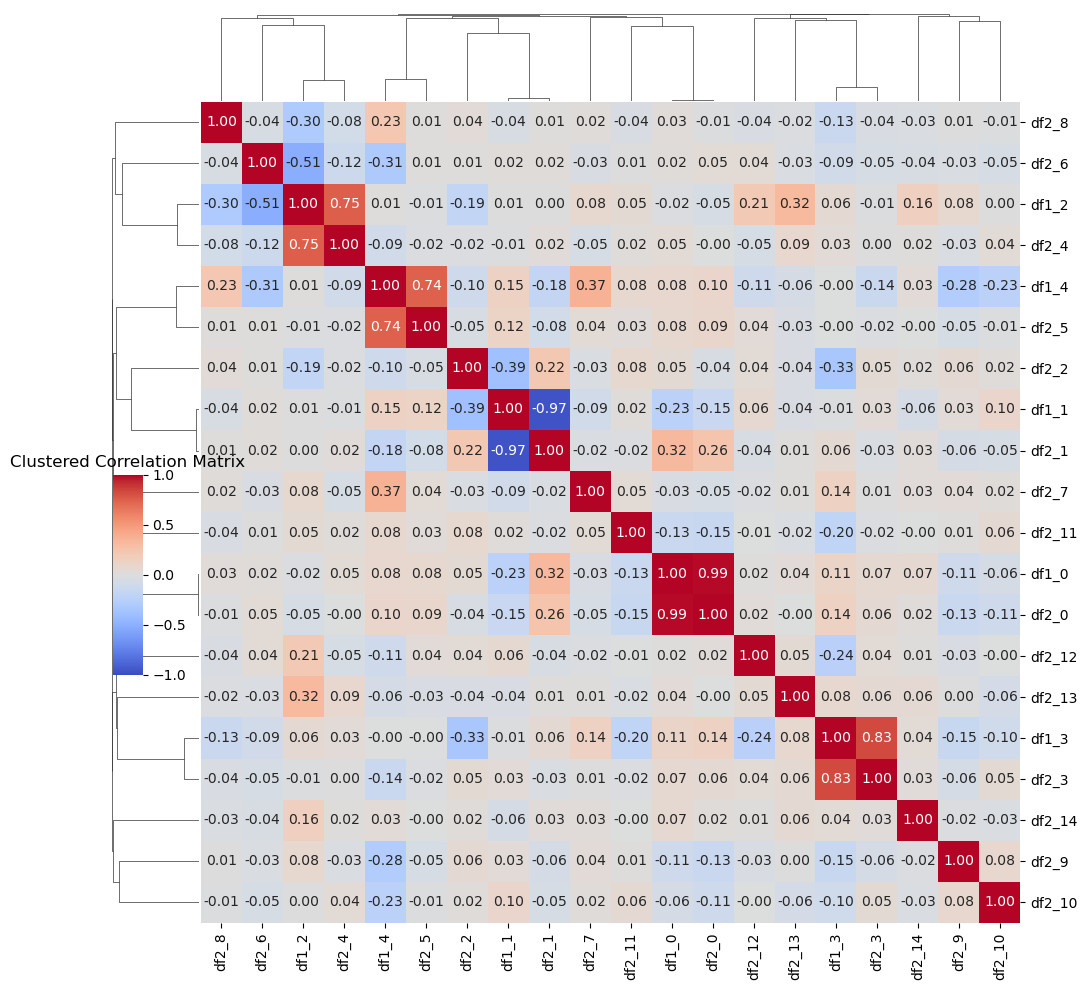

In [27]:
cross_corrs = get_clustered_correlation_matrix([subj_loadings_5c, subj_loadings_15c])

In [15]:
subj_loadings_30c = post_flica_filter(flica_out_path_32k_30c,
                                  sub_fn_32k,
                                  rs_thresh,
                                  subj_thresh)

Decomposition results from: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_32k_30c 

Modalities:


KeyboardInterrupt: 

## 26k with MRTRIX diffusion

Decomposition results from: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_26k_25c 

Modalities:
['dMRI', 'rs_mtl', 'rs_ifl', 'tbm']
Multimodal components with an MMI above 0.2:
(array([ 7, 19]),)
Components with subject dominance below 0.01:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24]),)
Multimodal components with both filters:
(array([ 7, 19]),)


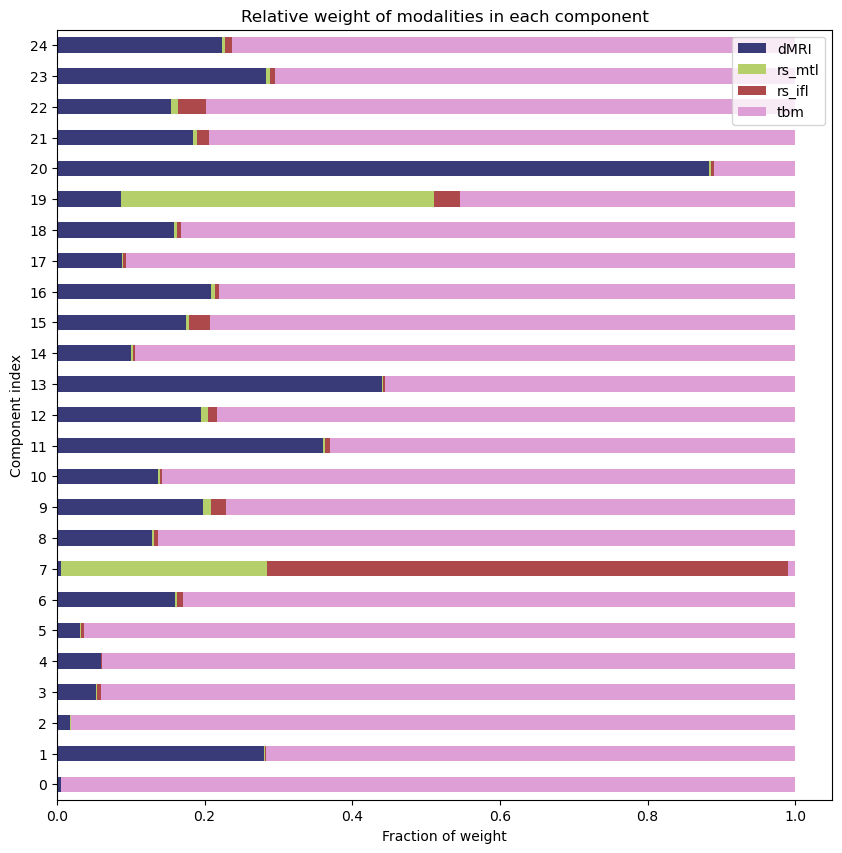

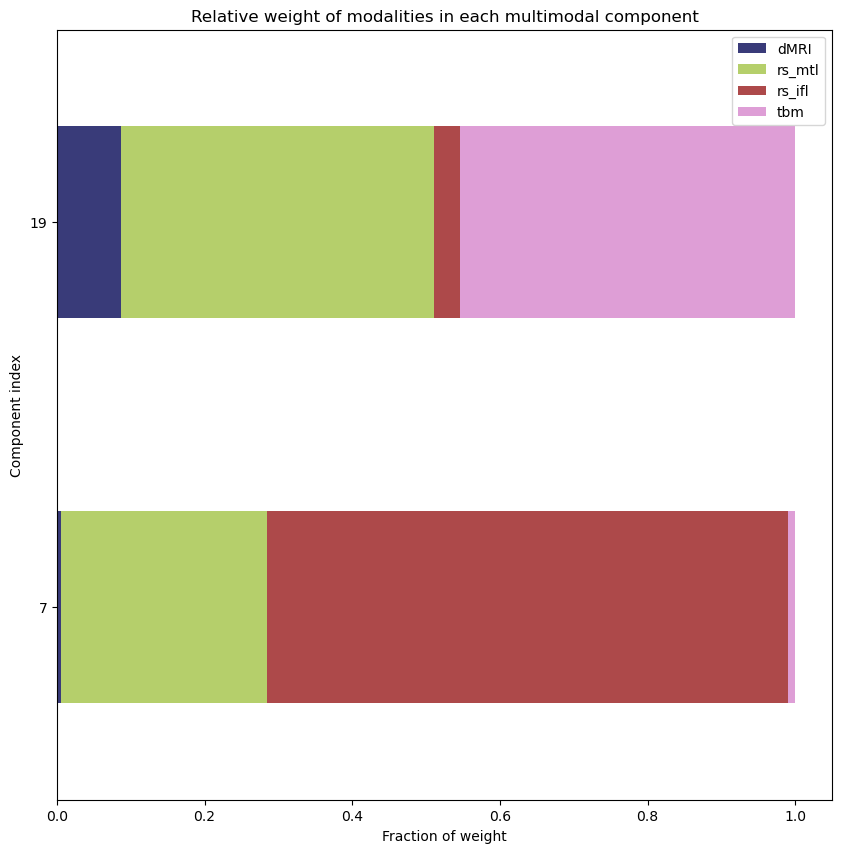

In [5]:
subj_loadings_25c, rs_comps_25c = post_flica_filter(flica_out_path_32k_30c,
                                  sub_fn_32k,
                                  rs_thresh,
                                  subj_thresh)

Decomposition results from: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_26k_50c 

Modalities:
['dMRI', 'rs_mtl', 'rs_ifl', 'tbm']
Multimodal components with an MMI above 0.2:
(array([11, 25]),)
Components with subject dominance below 0.01:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),)
Multimodal components with both filters:
(array([11, 25]),)


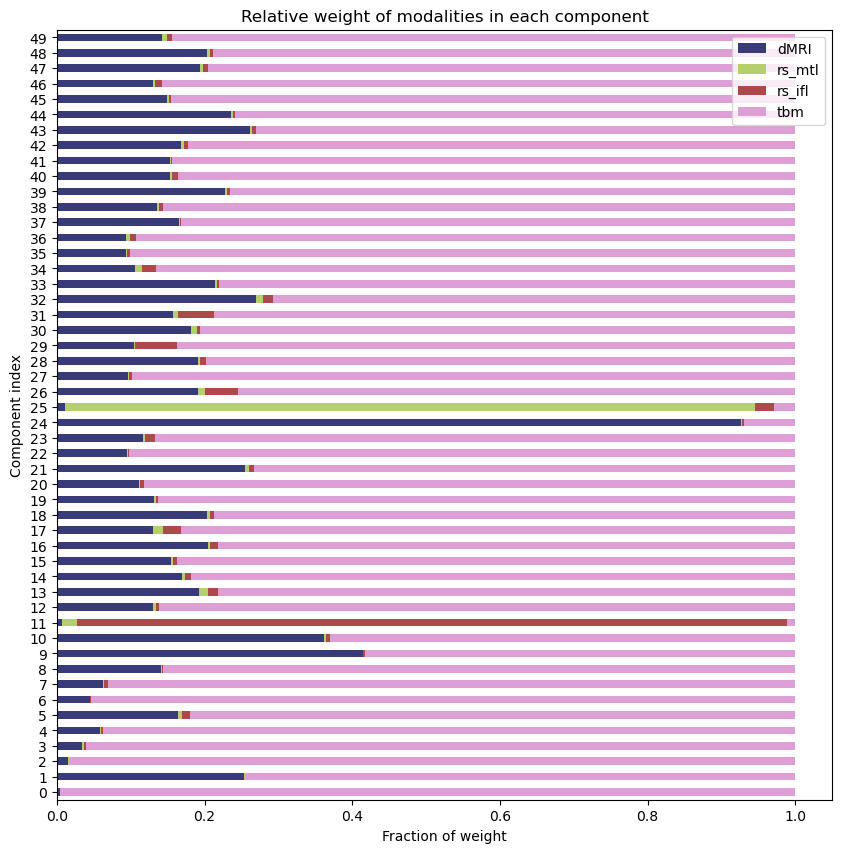

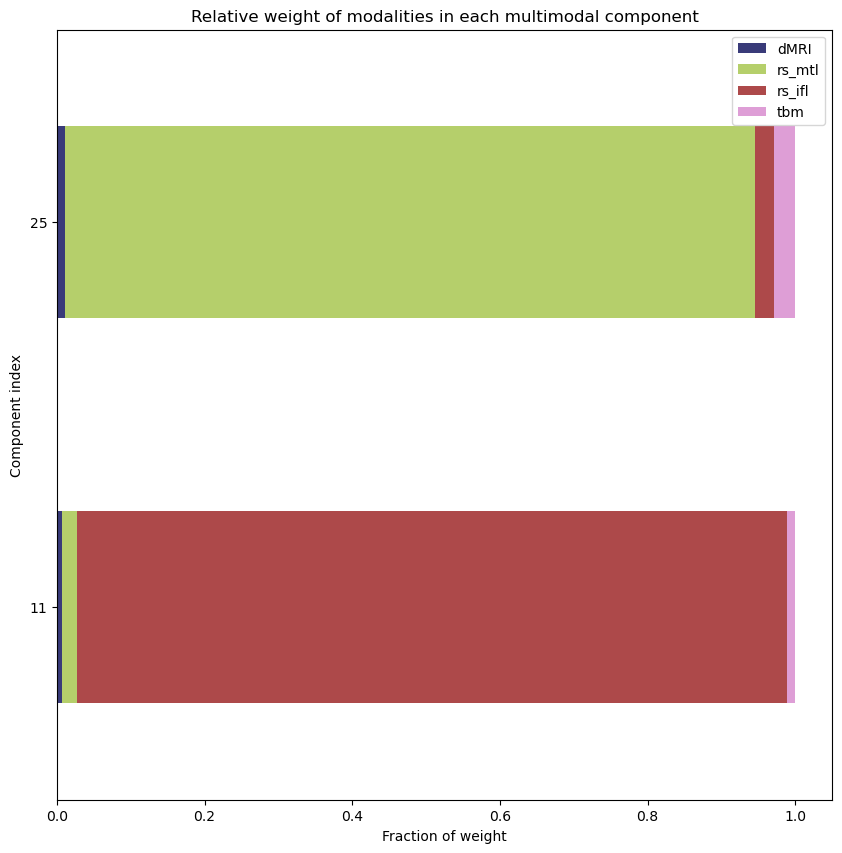

In [6]:
subj_loadings_50c, rs_comps_50c  = post_flica_filter(flica_out_path_50c,
                                  sub_fn,
                                  rs_thresh,
                                  subj_thresh)

Decomposition results from: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_26k_100c 

Modalities:
['dMRI', 'rs_mtl', 'rs_ifl', 'tbm']
Multimodal components with an MMI above 0.2:
(array([10, 23, 97, 99]),)
Components with subject dominance below 0.01:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),)
Multimodal components with both filters:
(array([10, 23, 97, 99]),)


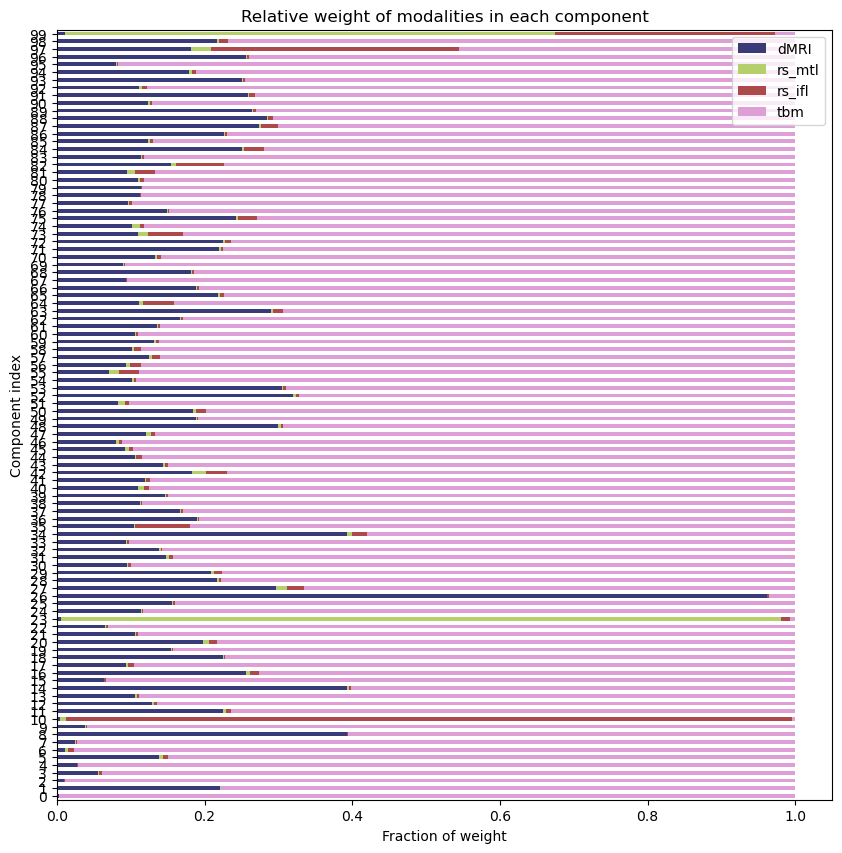

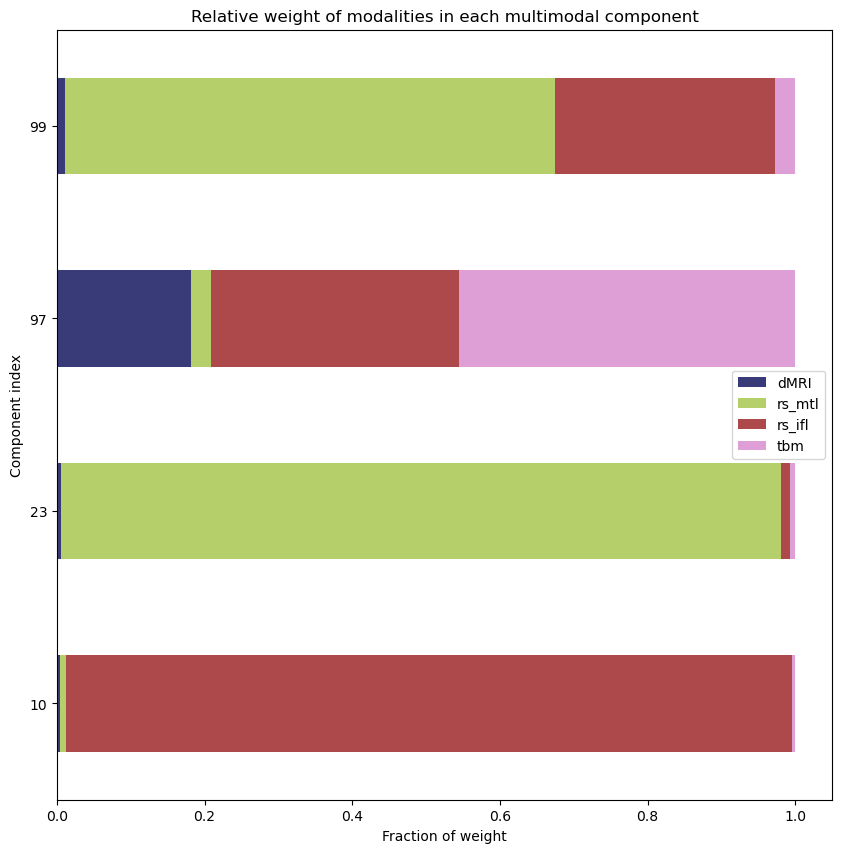

In [5]:
subj_loadings_100c, rs_comps_100c  = post_flica_filter(flica_out_path_100c,
                                  sub_fn,
                                  rs_thresh,
                                  subj_thresh,
                                  struc_comps_of_interest = [])

In [8]:
#combine and save output
subj_loadings_25c.columns = [str(x)+"_25c_26k" for x in subj_loadings_25c.columns]
subj_loadings_50c.columns = [str(x)+"_50c_26k" for x in subj_loadings_50c.columns]
subj_loadings_100c.columns = [str(x)+"_100c_26k" for x in subj_loadings_100c.columns]

out_df_26k = subj_loadings_25c.join(subj_loadings_50c).join(subj_loadings_100c)
output_gcta_regenie(os.path.join(cfs_path, "rs_ics_26k"), out_df_26k)

In [7]:
#plot components
figure_path = os.path.join(workspace_path, "results", "figures")

struc_100_26k = [13, 20, 34]
struc_100_26k_ext = [0, 2, 3, 5, 16, 26, 28, 48, 50, 57, 60, 62, 74, 83, 98]

plot_all_components_all_paths(flica_paths = [ flica_out_path_100c ],
                             components_lists = [ rs_comps_100c + struc_100_26k + struc_100_26k_ext ],
                             out_paths = [ os.path.join(figure_path, "100c_26k") ])

#plot_all_components_all_paths(flica_paths = [ flica_out_path_25c, flica_out_path_50c, flica_out_path_100c ],
#                                components_lists = [ rs_comps_25c, rs_comps_50c, rs_comps_100c ],
#                                out_paths= [ os.path.join(figure_path, "25c_26k"), os.path.join(figure_path, "50c_26k"), os.path.join(figure_path, "100c_26k") ] )


Running path: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_4mods_26k_100c
Plotting component number 10
Plot modality: dMRI


/home/jitame/bin/anaconda3/envs/results_env/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


Plot modality: rs_mtl
Plot modality: rs_ifl
Plot modality: tbm
Plotting component number 23
Plot modality: dMRI
Plot modality: rs_mtl
Plot modality: rs_ifl
Plot modality: tbm
Plotting component number 97
Plot modality: dMRI
Plot modality: rs_mtl
Plot modality: rs_ifl
Plot modality: tbm
Plotting component number 99
Plot modality: dMRI
Plot modality: rs_mtl
Plot modality: rs_ifl
Plot modality: tbm
Plotting component number 13
Plot modality: dMRI
Plot modality: rs_mtl
Plot modality: rs_ifl
Plot modality: tbm
Plotting component number 20
Plot modality: dMRI
Plot modality: rs_mtl
Plot modality: rs_ifl
Plot modality: tbm
Plotting component number 34
Plot modality: dMRI
Plot modality: rs_mtl
Plot modality: rs_ifl
Plot modality: tbm
Plotting component number 0
Plot modality: dMRI
Plot modality: rs_mtl
Plot modality: rs_ifl
Plot modality: tbm
Plotting component number 2
Plot modality: dMRI
Plot modality: rs_mtl
Plot modality: rs_ifl
Plot modality: tbm
Plotting component number 3
Plot modality: 

## 28k with FA and MD

In [10]:
subj_loadings_25c_28k, rs_comps_25c_28k  = post_flica_filter(flica_out_path_28k_25c,
                                  sub_fn_28k,
                                  rs_thresh,
                                  subj_thresh)

Decomposition results from: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_5mods_28k_25c 

Modalities:


FileNotFoundError: [Errno 2] No such file or directory: '/data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_5mods_28k_25c/order_of_loaded_data.txt'

Decomposition results from: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_5mods_28k_50c 

Modalities:
['rs_mtl', 'rs_ifl', 'tbm', 'fa', 'md']
Multimodal components with an MMI above 0.2:
(array([14, 31]),)
Components with subject dominance below 0.01:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),)
Multimodal components with both filters:
(array([14, 31]),)


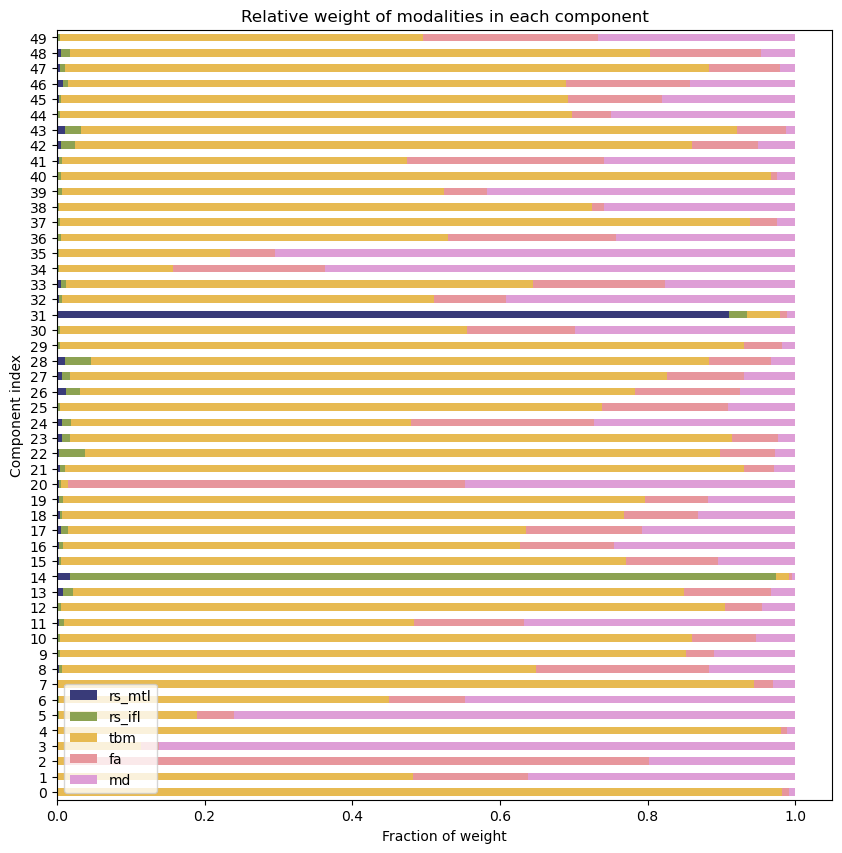

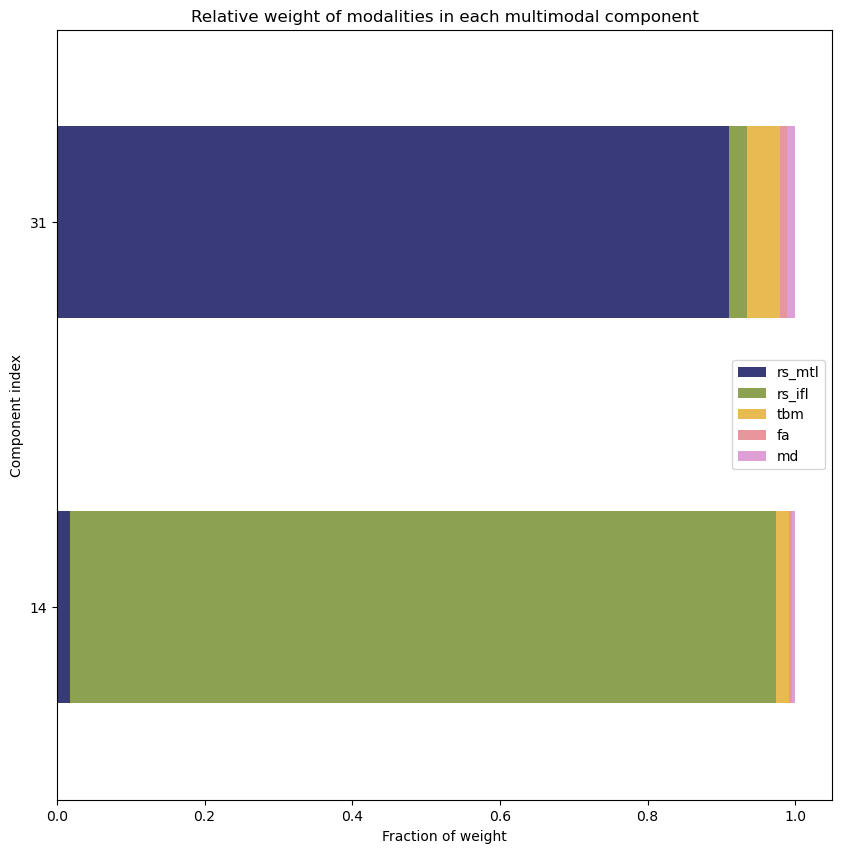

In [15]:
subj_loadings_50c_28k, rs_comps_50c_28k  = post_flica_filter(flica_out_path_28k_50c,
                                  sub_fn_28k,
                                  rs_thresh,
                                  subj_thresh)

Decomposition results from: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_5mods_28k_100c 

Modalities:
['rs_mtl', 'rs_ifl', 'tbm', 'fa', 'md']
Multimodal components with an MMI above 0.2:
(array([15, 29, 99]),)
Components with subject dominance below 0.01:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),)
Multimodal components with both filters:
(array([15, 29, 99]),)


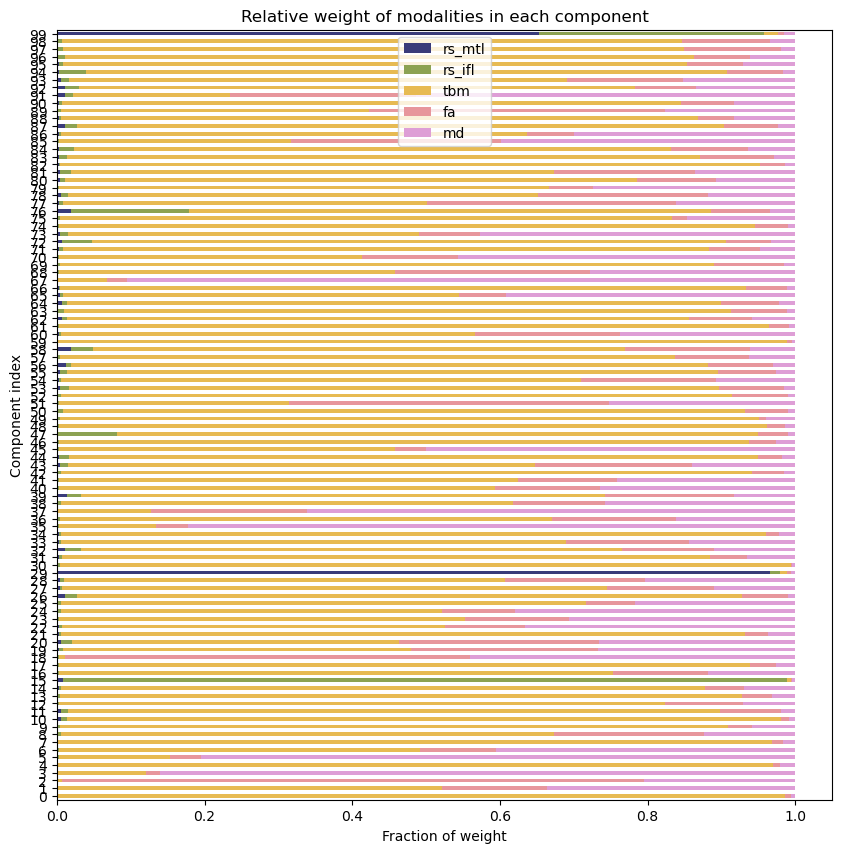

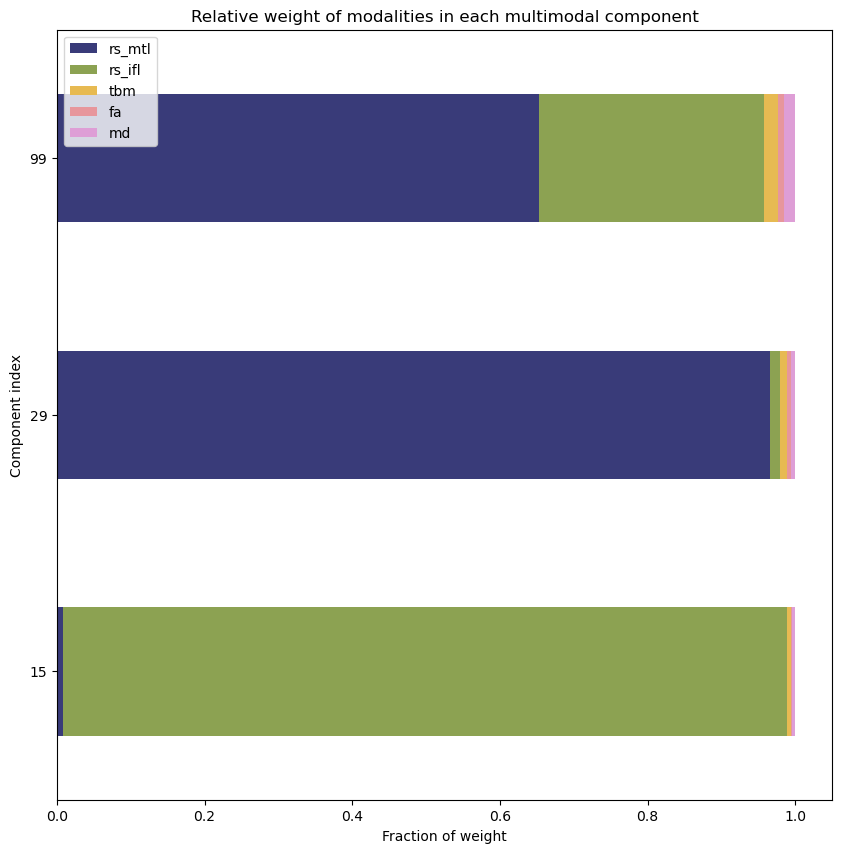

In [16]:
subj_loadings_100c_28k, rs_comps_100c_28k  = post_flica_filter(flica_out_path_28k_100c,
                                  sub_fn_28k,
                                  rs_thresh,
                                  subj_thresh)

In [17]:
#combine and save output
#subj_loadings_25c_28k.columns = [str(x)+"_25c_28k" for x in subj_loadings_25c.columns]
subj_loadings_50c_28k.columns = [str(x)+"_50c_28k" for x in subj_loadings_50c_28k.columns]
subj_loadings_100c_28k.columns = [str(x)+"_100c_28k" for x in subj_loadings_100c_28k.columns]

out_df_28k = subj_loadings_50c_28k.join(subj_loadings_100c_28k)
output_gcta_regenie(os.path.join(cfs_path, "rs_ics_28k"), out_df_28k)

In [20]:
#plot components
figure_path = os.path.join(workspace_path, "results", "figures")

plot_all_components_all_paths(flica_paths = [ flica_out_path_28k_50c, flica_out_path_28k_100c ],
                                components_lists = [ rs_comps_50c_28k, rs_comps_100c_28k ],
                                out_paths= [ os.path.join(figure_path, "50c_28k"), os.path.join(figure_path, "100c_28k") ] )

Running path: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_5mods_28k_50c
Plotting component number 14
Plot modality: rs_mtl
Plot modality: rs_ifl
Plot modality: tbm
Plot modality: fa
Plot modality: md
Plotting component number 31
Plot modality: rs_mtl
Plot modality: rs_ifl
Plot modality: tbm
Plot modality: fa
Plot modality: md
Running path: /data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/FLICA_multimodal/flica_out_5mods_28k_100c
Plotting component number 15
Plot modality: rs_mtl
Plot modality: rs_ifl
Plot modality: tbm
Plot modality: fa
Plot modality: md
Plotting component number 29
Plot modality: rs_mtl
Plot modality: rs_ifl
Plot modality: tbm
Plot modality: fa
Plot modality: md
Plotting component number 99
Plot modality: rs_mtl
Plot modality: rs_ifl
Plot modality: tbm
Plot modality: fa
Plot modality: md


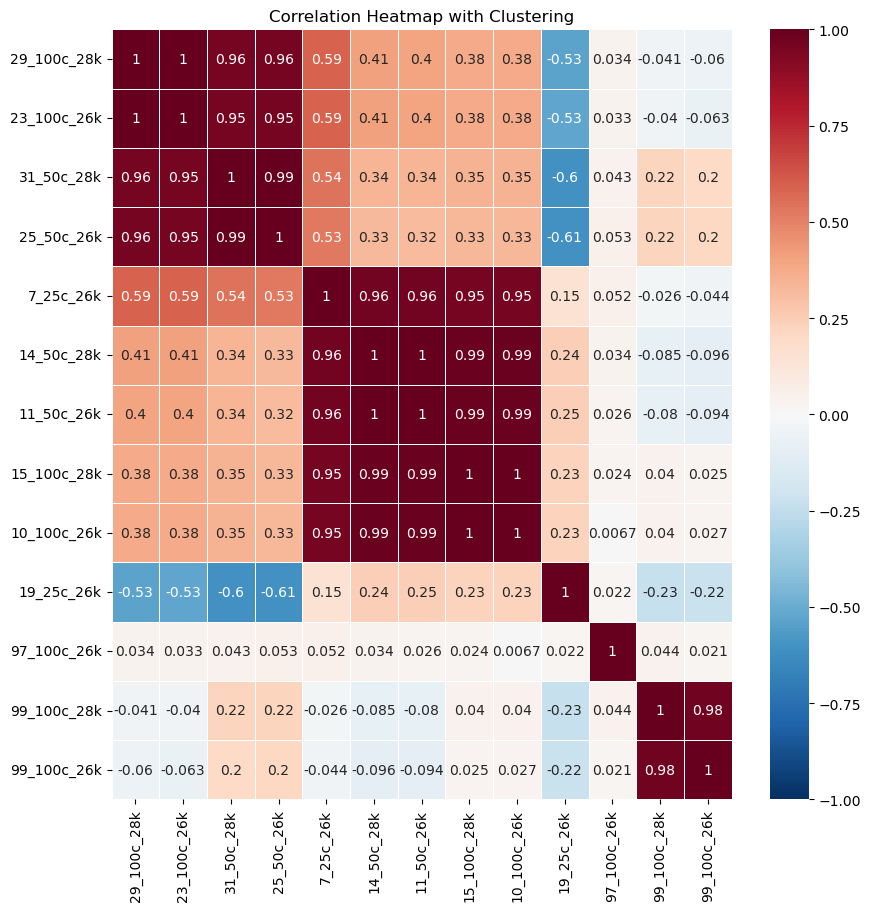

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster import hierarchy

all_df = out_df_28k.join(out_df_26k, rsuffix="_26k")

# Drop columns you don't want in correlation calculation
#columns_to_drop = ["IID", "FID", "IID_26k"]
# all_df.drop(columns_to_drop, axis=1, inplace=True)

# Create a correlation matrix
#correlation_matrix = all_df.corr()

# Perform hierarchical clustering to reorder rows and columns
row_linkage = hierarchy.linkage(correlation_matrix, method='average')
column_linkage = hierarchy.linkage(correlation_matrix.T, method='average')

# Get row and column index orders from clustering
row_index = hierarchy.leaves_list(row_linkage)
column_index = hierarchy.leaves_list(column_linkage)

# Reorder the correlation matrix
correlation_matrix_clustered = correlation_matrix.iloc[row_index, column_index]

# Set up the matplotlib figure
fig, ax = plt.subplots(1, figsize=(10, 10))

# Create the heatmap
sns.heatmap(correlation_matrix_clustered,
            vmin=-1, vmax=1, cmap="RdBu_r",
            linewidth=0.5, annot=True, ax=ax)

# Add a title
plt.title('Correlation Heatmap with Clustering')

# Show the plot
plt.show()


In [ ]:
all_df = out_df_28k.join(out_df_26k, rsuffix="_26k")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster import hierarchy



# Drop columns you don't want in correlation calculation
#columns_to_drop = ["IID", "FID", "IID_26k"]
# all_df.drop(columns_to_drop, axis=1, inplace=True)

# Create a correlation matrix
#correlation_matrix = all_df.corr()

# Perform hierarchical clustering to reorder rows and columns
row_linkage = hierarchy.linkage(correlation_matrix, method='average')
column_linkage = hierarchy.linkage(correlation_matrix.T, method='average')

# Get row and column index orders from clustering
row_index = hierarchy.leaves_list(row_linkage)
column_index = hierarchy.leaves_list(column_linkage)

# Reorder the correlation matrix
correlation_matrix_clustered = correlation_matrix.iloc[row_index, column_index]

# Set up the matplotlib figure
fig, ax = plt.subplots(1, figsize=(10, 10))

# Create the heatmap
sns.heatmap(correlation_matrix_clustered,
            vmin=-1, vmax=1, cmap="RdBu_r",
            linewidth=0.5, annot=True, ax=ax)

# Add a title
plt.title('Correlation Heatmap with Clustering')

# Show the plot
plt.show()
